In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os

%matplotlib inline

In [2]:
# create the path for the file

myPath = os.path.join('/Users', 'Bryan', 'Documents', 'Programming',
                      'time_series_forecasting_with_python',
                      'UDEMY_TSA_FINAL','Data')

print(myPath)

os.chdir(myPath)

/Users/Bryan/Documents/Programming/time_series_forecasting_with_python/UDEMY_TSA_FINAL/Data


In [3]:
df = pd.read_csv('Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['Sales']

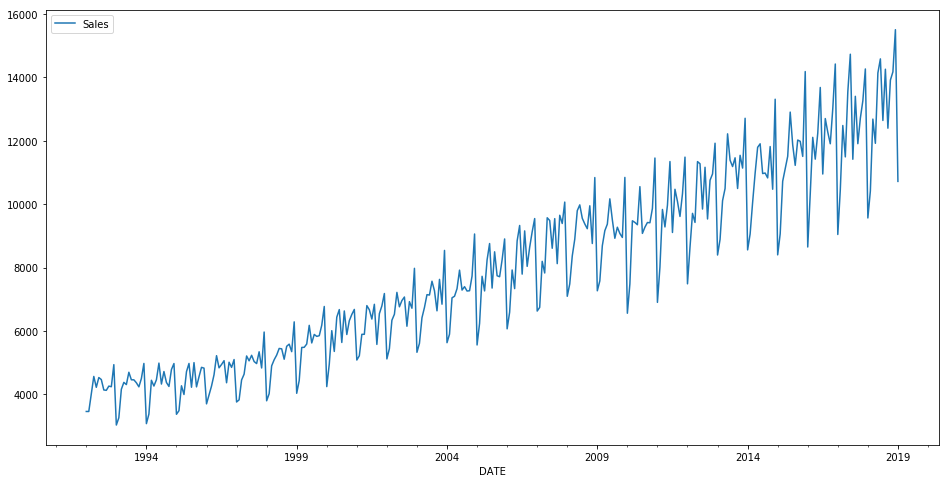

In [5]:
df.plot(figsize=(16,8))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

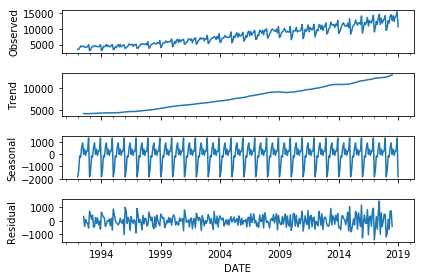

In [7]:
result = seasonal_decompose(df['Sales'])
result.plot();

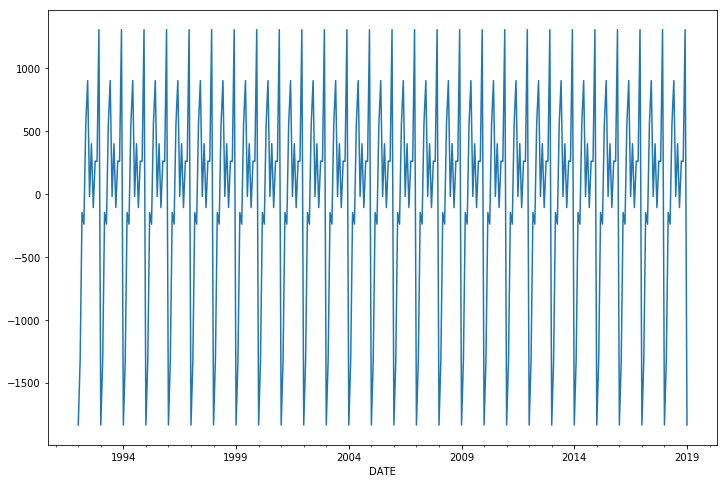

In [8]:
result.seasonal.plot(figsize=(12,8))

In [9]:
# train test split

len(df)

325

In [10]:
# forecast 1 year into future
train = df.iloc[:313]
test = df.iloc[313:]

In [11]:
len(test)

12

In [12]:
# alternate method
# nobs = number of observations to forecast
nobs = 12

train = df.iloc[:-nobs]
test = df.iloc[-nobs:]

len(test)

12

In [13]:
# need to scale data to 0 - 1 
from sklearn.preprocessing import MinMaxScaler

In [14]:
# find the max is the fit and dividing by max is transform
scaler = MinMaxScaler()

In [15]:
scaler.fit(train) #find the max value

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
# use the preprocessing time series generator
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [18]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

In [19]:
# n_input is the number of 'lags' to use as inputs to use for next time step
# batch size will cut the data set down

n_input = 2
n_features = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [20]:
len(scaled_train)

313

In [21]:
# should be n_input less than length of train

len(generator)

311

In [22]:
X,y = generator[0]
X

array([[[0.03658432],
        [0.03649885]]])

In [23]:
X.shape

(1, 2, 1)

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [30]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [31]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit_generator(train_generator, epochs=25)

Epoch 1/25
301/301 [==============================] - 8s 28ms/step - loss: 0.0151
Epoch 2/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0109
Epoch 3/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0086
Epoch 4/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0085
Epoch 5/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0077
Epoch 6/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0056
Epoch 7/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0045
Epoch 8/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0038
Epoch 9/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0024
Epoch 10/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0020
Epoch 11/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0024
Epoch 12/25
301/301 [==============================] - 7s 24ms/step - loss: 0.0019
Epoch 13/25
3

In [34]:
model.history.history.keys()

dict_keys(['loss'])

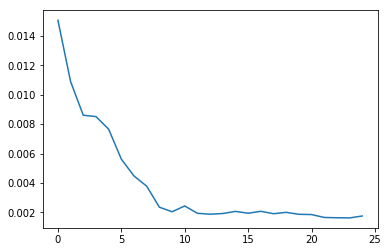

In [35]:
plt.plot(range(len(model.history.history['loss'])), model.history.history['loss'])

In [36]:
# 12 history steps ---> step 13
# last 12 points train --> pt 1 of test data

In [37]:
first_eval_batch = scaled_train[-12:]

In [39]:
first_eval_batch = first_eval_batch.reshape((1,n_input, n_features))

In [41]:
model.predict(first_eval_batch)

array([[0.7447778]], dtype=float32)

In [42]:
scaled_test

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

# FORECAST USING RNN MODEL

In [46]:
# holding predictions in empty list
test_predictions = []


# last n_inputs from the training set
first_eval_batch = scaled_train[-n_input:]

current_batch = first_eval_batch.reshape((1,n_input, n_features))

# how far into the future to forecast
# set to length of test set
# can change the range and go into the future
for i in range(len(test)):
    
    # one time step ahead of historical 12 points
    current_pred = model.predict(current_batch)[0]
    
    # store in prediction
    test_predictions.append(current_pred)
    
    # UPDATE current batch to include prediction
    # dropping first and adding the prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

In [47]:
test_predictions

[array([0.7447778], dtype=float32),
 array([0.8845774], dtype=float32),
 array([0.8387416], dtype=float32),
 array([1.0005704], dtype=float32),
 array([1.0557492], dtype=float32),
 array([0.8341915], dtype=float32),
 array([0.9714809], dtype=float32),
 array([0.86133975], dtype=float32),
 array([0.9319183], dtype=float32),
 array([0.9721681], dtype=float32),
 array([1.024785], dtype=float32),
 array([0.66417676], dtype=float32)]

In [49]:
# invert the scaling 
true_predictions = scaler.inverse_transform(test_predictions)

In [50]:
true_predictions

array([[11744.15546644],
       [13379.67092693],
       [12843.43798441],
       [14736.67330205],
       [15382.20963264],
       [12790.20637184],
       [14396.35511941],
       [13107.81371075],
       [13933.51246125],
       [14404.39446104],
       [15019.96020412],
       [10801.20393986]])

In [53]:
test['Predictions'] = true_predictions
test

/Users/Bryan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Sales,Predictions
DATE,,
2018-02-01,10415,11744.155466
2018-03-01,12683,13379.670927
2018-04-01,11919,12843.437984
2018-05-01,14138,14736.673302
2018-06-01,14583,15382.209633
2018-07-01,12640,12790.206372
2018-08-01,14257,14396.355119
2018-09-01,12396,13107.813711
2018-10-01,13914,13933.512461


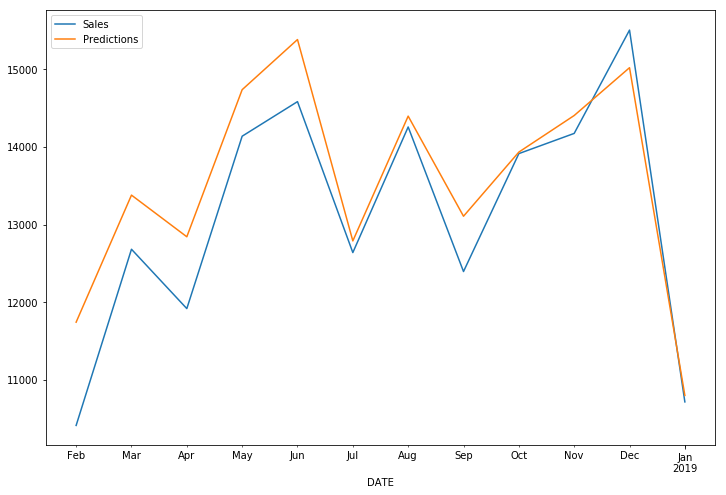

In [54]:
test.plot(figsize=(12,8))

In [55]:
pwd

'/Users/Bryan/Documents/Programming/time_series_forecasting_with_python/UDEMY_TSA_FINAL/Data'

In [56]:
model.save('myLSTM.h5')

In [57]:
os.listdir()

['RestaurantVisitors.csv',
 'starbucks.csv',
 'population_by_state.csv',
 'BeerWineLiquor.csv',
 'myLSTM.h5',
 'MaunaLoaDailyTemps.csv',
 'rhine_river_discharge.csv',
 'monthly_milk_production.csv',
 'Miles_Traveled.csv',
 'danube_river_discharge.csv',
 'RideAustin.csv',
 'HospitalityEmployees.csv',
 'PCEPersonalSpending.csv',
 'uspopulation.csv',
 'samples.csv',
 'EnergyProduction.csv',
 'DailyTotalFemaleBirths.csv',
 'M2SLMoneyStock.csv',
 'price_of_ground_chuck.csv',
 'PriceIndexCatFood.csv',
 'PriceIndexDogFood.csv',
 'PublishingEmployees.csv',
 'macrodata.csv',
 'co2_mm_mlo.csv',
 'Retail_Sales_Beer_Liquor.csv',
 'UMTMVS.csv',
 'TradeInventories.csv',
 'MtWashingtonDailyTemps.csv',
 'Alcohol_Sales.csv',
 'population_by_county.csv',
 'airline_passengers.csv',
 'Food_Products_Value.csv']

In [58]:
# to load the model back in

from keras.models import load_model

In [59]:
new_model = load_model('myLSTM.h5')

In [60]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
